# Tutorial 4: Underfitting and Overfitting: How to Prevent Them

## Implementing an Overfitted Model

Through this tutorial you further learn how to use `torch.nn` module of torch to implement a neural network in only few lines of code.

We first import all required packages.

In [1]:
# We import torch and the nn module
import torch
import torch.nn as nn

# We import NumPy and tqdm
import numpy as np
from tqdm import tqdm

# We need few items from Scikit-Learn
import sklearn.datasets as DataSets
from sklearn.model_selection import train_test_split

# Also we need to plot few curves
import matplotlib.pyplot as plt

### Task 1: Make Training Mini-Batches

In [26]:
dataset = DataSets.make_classification(n_samples = 10000
                                       , n_features = 20
                                       , n_informative=5
                                       , n_redundant=15
                                       , random_state=1)
X, v = dataset

In [27]:
X.shape

(10000, 20)

In [28]:
v[0]

1

Below you can implement the function

In [29]:
def data_splitter(X, v, batch_size, train_size):
    '''
    X is list of data-points
    v is list of labels
    train_size is the fraction of data-points used for training
    '''
    X_train, X_test, v_train, v_test = train_test_split(X, v
        , train_size=train_size
        , shuffle = True
        )
    X_train = torch.tensor(X_train,dtype=torch.float32)
    v_train = torch.tensor(v_train,dtype=torch.float32).reshape(-1,1)
    X_test = torch.tensor(X_test ,dtype=torch.float32)
    v_test = torch.tensor(v_test ,dtype=torch.float32).reshape(-1, 1)
    batch_indx = torch.arange(0, len(X_train), step=batch_size)
    return X_train, v_train, X_test, v_test, batch_indx

In [30]:
X_train, v_train, X_test, v_test, batch_indx = data_splitter(X, v, batch_size=1000, train_size=0.65)

In [31]:
batch_indx

tensor([   0, 1000, 2000, 3000, 4000, 5000, 6000])

### Task 2: Implementing an FNN

For this task you can use `nn.Layer()`. You mainly need to complete the following `class`.

In [69]:
class myClassifier(nn.Module):
    def __init__(self, show_print=False):
        super().__init__()

        self.show_print = show_print

        self.layer1 = nn.Linear(20, 64)
        self.active1 = nn.ReLU()

        self.layer2 = nn.Linear(64, 32)
        self.active2 = nn.ReLU()

        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        if self.show_print: print("input shape", x.shape)
        
        x = self.active1(self.layer1(x))
        if self.show_print: print("shape after first hidden layer", x.shape)
        
        x = self.active2(self.layer2(x))
        if self.show_print: print("shape after second hidden layer", x.shape)
        
        x = self.sigmoid(self.output(x))
        if self.show_print: print("shape after output layer", x.shape)
        return x

In [70]:
classifier = myClassifier(show_print=True)

# Input four datapoints
classifier.forward(X_train[1:5])

input shape torch.Size([4, 20])
shape after first hidden layer torch.Size([4, 64])
shape after second hidden layer torch.Size([4, 32])
shape after output layer torch.Size([4, 1])


tensor([[0.4494],
        [0.4238],
        [0.3630],
        [0.4616]], grad_fn=<SigmoidBackward0>)

In [71]:
v_test[1:5]

tensor([[0.],
        [1.],
        [1.],
        [1.]])

### Task 3: Backpropagation and Optimizer
We now learn how we can use the autograd of PyTorch to implement backpropagation. Simply complete the following code and run it to see how autograd works.

In [62]:
# first, instantiate the model 
myModel = myClassifier()
# now, define the loss
loss_fn = nn.BCELoss()

# split the dataset via function data_splitter()
X_train, v_train, X_test, v_test, batch_indx = data_splitter(X, v, batch_size=1000, train_size=0.65)

# take a sample point from training dataset
x, v_ =  X_train[0], v_train[0]

# forward pass
y = myModel.forward(x)
Loss = loss_fn(y, v_)

# backward pass
Loss.backward()

input shape torch.Size([20])


We can now access the computed gradient of the loss with respect to the output bias using the following code.

In [63]:
myModel.output.bias.grad

tensor([0.4636])

In [64]:
myModel.layer1.weight.grad

tensor([[ 0.0246,  0.0077, -0.0395,  ...,  0.0200,  0.0089,  0.0326],
        [-0.0273, -0.0086,  0.0439,  ..., -0.0223, -0.0099, -0.0362],
        [-0.0110, -0.0034,  0.0176,  ..., -0.0089, -0.0040, -0.0145],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0037, -0.0011,  0.0059,  ..., -0.0030, -0.0013, -0.0049],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [65]:
myModel.layer1.weight.grad.shape

torch.Size([64, 20])

We can further define the optimizer for our model as follows:

In [72]:
# first, instantiate the model 
myModel = myClassifier()

# now define the optimizer
optimizer = torch.optim.Adam(params=myModel.parameters()# pass the model parameters
                        , lr=0.0001 # this specifies the learning rate
                        )

### Task 4: Implementing Training and Test Loop
Now that we have all the components, we put all these components together to implement the training loop.

In [74]:
def training_loop(model, weight_decay=0, l1_regularizer=False, l1_lambda=0):
    '''
    parameters:
        model: an instance of nn.Module
        weight_decay: float, L2 regularization coefficient
        l1_regularizer: boolean, whether to use L1 regularization
        l1_lambda: float, L1 regularization coefficient
    '''
    
    # define the loss and optimizer
    loss_fn = nn.BCELoss() # binary cross-entropy
    optimizer = torch.optim.Adam(params=model.parameters()
                                 , lr=0.0001 # this specifies the learning rate
                                 , weight_decay= weight_decay
                                 )

    # set the training parameters
    n_epochs = 300   # number of epochs
    batch_size = 40  # batch size

    # specify training and test datasets and the batch indices
    # use data_splitter() and X, v are generated by Scikit-Learn
    X_train, v_train, X_test, v_test, batch_indx = data_splitter(X, v, batch_size=batch_size, train_size=0.80)

    # make empty list to save training and test risk
    train_risk = []
    test_risk = []

    # training loop

    # we visualize the training progress via tqdm
    with tqdm(range(n_epochs), unit="epoch") as epoch_bar:
        epoch_bar.set_description("training loop")
        for epoch in epoch_bar:

            # tell pytorch that you start training
            model.train()

            for indx in batch_indx:
                # take a batch of samples
                X_batch = X_train[indx:indx+batch_size]
                v_batch = v_train[indx:indx+batch_size]

                # pass forward the mini-batch
                y_batch = model.forward(X_batch)

                # compute the loss
                loss = loss_fn(y_batch, v_batch)

                if l1_regularizer:
                    l1_penalty = 0
                    for param in model.parameters():
                        l1_penalty += torch.sum(torch.abs(param))
                    
                    loss = loss + l1_lambda * l1_penalty  # Add L1 penalty to the loss
                
                # backward pass
                # first make gradient zero
                optimizer.zero_grad()
                # then, compute the gradient of loss
                loss.backward()
                # now update weights by one optimization step
                optimizer.step()

            # we are done with one epoch
            # we now evaluate training and test risks
            # first we tell pytorch we are doing evaluation
            model.eval()

            # now we evaluate the training risk
            y_train = model.forward(X_train)
            CE_train = loss_fn(y_train, v_train)
            train_risk.append(CE_train.item())

            # then we evaluate the test risk
            y_test = model.forward(X_test)
            CE_test = loss_fn(y_test, v_test)
            test_risk.append(CE_test.item())
        return train_risk, test_risk

We can now try training our model by passing the model to the training loop:

training loop: 100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [01:14<00:00,  4.01epoch/s]


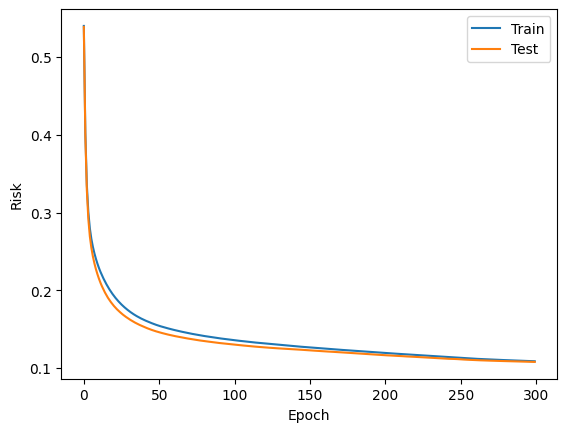

In [76]:
myModel = myClassifier()
train_risk, test_risk = training_loop(myModel)

plt.plot(train_risk, label='Train')
plt.plot(test_risk, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Risk')
plt.legend()
plt.show()

### Task 5: Overfitting
Now we increase the model capacity to see the overfitting clearly. This can be done by completing the following code.

In [33]:
class overfitClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(20, 200)
        self.active1 = nn.ReLU()

        self.layer2 = nn.Linear(200, 120)
        self.active2 = nn.ReLU()

        self.layer3 = nn.Linear(120, 70)
        self.active3 = nn.ReLU()

        self.layer4 = nn.Linear(70, 50)
        self.active4 = nn.ReLU()

        self.layer5 = nn.Linear(50, 30)
        self.active5 = nn.ReLU()

        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.active1(self.layer1(x))
        x = self.active2(self.layer2(x))
        x = self.active3(self.layer3(x))
        x = self.active4(self.layer4(x))
        x = self.active5(self.layer5(x))
        x = self.sigmoid(self.output(x))
        return x

We now try training this model and look at the learning curves.

training loop: 100%|██████████| 300/300 [00:48<00:00,  6.25epoch/s]


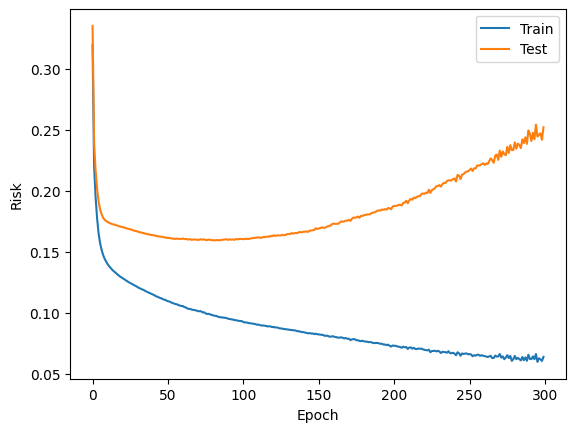

In [19]:
not_regularized_model = overfitClassifier()
train_risk, test_risk = training_loop(not_regularized_model) # complete

plt.plot(train_risk, label='Train')
plt.plot(test_risk, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Risk')
plt.legend()
plt.show()

## Dropout and Batch-Normalization

### Technique 1: Dropout
Dropout can be readily implemented via `nn.Dropout()`. We add it to our implementation in the following code.

Definition from PyTorch: During training, randomly zeroes some of the elements of the input tensor with probability p.

Note that the definition p is dropout probability instead of retaining probability in the slide. 


In [25]:
dropout = nn.Dropout(p=0.8)
x = torch.randn(20, 2)
output = dropout(x)
output

tensor([[-0.0000, -0.0000],
        [ 0.0000, -0.0000],
        [ 0.0000, -0.0000],
        [ 0.0000,  0.0000],
        [-0.0000,  0.0000],
        [-0.0000,  0.0000],
        [-0.0000, -0.0000],
        [ 0.0000, -4.1912],
        [-0.0000, -0.0000],
        [ 0.4633, 14.1892],
        [ 7.4810, -0.0000],
        [ 0.0000,  0.0000],
        [-2.4653,  0.0000],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [ 0.0000, -0.0000],
        [ 8.4594, -0.0000],
        [ 0.0000, -0.0000],
        [ 0.0000, -0.0000],
        [-0.0000, -6.2752]])

In [24]:
class RegularizedByDropOutNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.dropout1 = nn.Dropout(0.2)
        self.layer1 = nn.Linear(20, 200)
        self.active1 = nn.ReLU()

        self.dropout2 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(200, 120)
        self.active2 = nn.ReLU()

        self.dropout3 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(120, 70)
        self.active3 = nn.ReLU()

        self.dropout4 = nn.Dropout(0.4)
        self.layer4 = nn.Linear(70, 50)
        self.active4 = nn.ReLU()

        self.dropout5 = nn.Dropout(0.4)
        self.layer5 = nn.Linear(50, 30)
        self.active5 = nn.ReLU()

        self.dropoutOut = nn.Dropout(0.4)
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(x)
        x = self.active1(self.layer1(x))
        x = self.active2(self.layer2(self.dropout2(x)))
        x = self.active3(self.layer3(self.dropout3(x)))
        x = self.active4(self.layer4(self.dropout4(x)))
        x = self.active5(self.layer5(self.dropout5(x)))
        x = self.sigmoid(self.output(self.dropoutOut(x)))
        return x

We can now try training this model to see the impact of Dropout.

training loop: 100%|██████████| 300/300 [01:00<00:00,  4.98epoch/s]


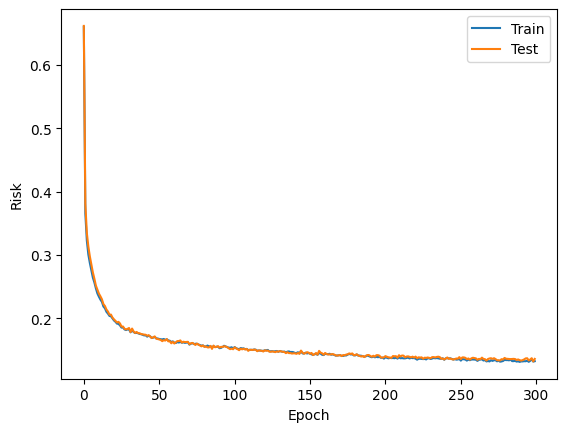

In [26]:
dropout_regularized_model = RegularizedByDropOutNet()
train_risk, test_risk = training_loop(dropout_regularized_model)# complete

plt.plot(train_risk, label='Train')
plt.plot(test_risk, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Risk')
plt.legend()
plt.show()

### Technique 2: Batch-Normalization
Let's now implement batch-normalization. For our model, we can readily implement one-dimensional batch-normalization via `nn.BatchNorm1d()`. 2D and 3D batch-normalization are useful in CNN, which we could practice in the next assignment.

In [21]:
class RegularizedByDropOutAndBatchNormNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.dropout1 = nn.Dropout(0.2)
        self.layer1 = nn.Linear(20, 200)
        self.active1 = nn.ReLU()
        self.BN1 = nn.BatchNorm1d(200)

        self.dropout2 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(200, 120)
        self.active2 = nn.ReLU()
        self.BN2 = nn.BatchNorm1d(120)

        self.dropout3 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(120, 70)
        self.active3 = nn.ReLU()
        self.BN3 = nn.BatchNorm1d(70)

        self.dropout4 = nn.Dropout(0.4)
        self.layer4 = nn.Linear(70, 50)
        self.active4 = nn.ReLU()
        self.BN4 = nn.BatchNorm1d(50)

        self.dropout5 = nn.Dropout(0.4)
        self.layer5 = nn.Linear(50, 30)
        self.active5 = nn.ReLU()
        self.BN5 = nn.BatchNorm1d(30)

        self.dropoutOut = nn.Dropout(0.4)
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(x)
        x = self.BN1(self.active1(self.layer1(x)))
        x = self.BN2(self.active2(self.layer2(self.dropout2(x))))
        x = self.BN3(self.active3(self.layer3(self.dropout3(x))))
        x = self.BN4(self.active4(self.layer4(self.dropout4(x))))
        x = self.BN5(self.active5(self.layer5(self.dropout5(x))))
        x = self.sigmoid(self.output(self.dropoutOut(x)))
        return x

We can now try training this model.

training loop: 100%|██████████| 300/300 [03:37<00:00,  1.38epoch/s]


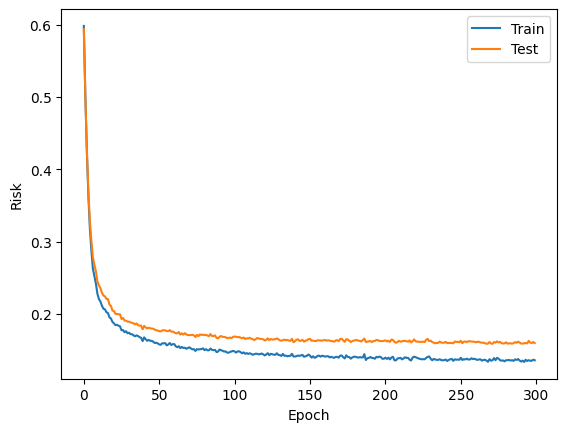

In [28]:
dropout_and_batchnorm_regularized_model = RegularizedByDropOutAndBatchNormNet()
train_risk, test_risk = training_loop(dropout_and_batchnorm_regularized_model)

plt.plot(train_risk, label='Train')
plt.plot(test_risk, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Risk')
plt.legend()
plt.show()

### Technique 3: L2 Regularization

training loop: 100%|██████████████████████████████████████████████████████████████| 300/300 [03:27<00:00,  1.45epoch/s]


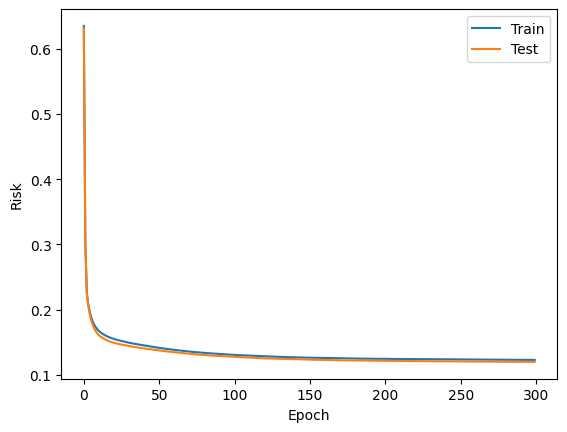

In [30]:
l2_regularized_model = overfitClassifier()
train_risk, test_risk = training_loop(l2_regularized_model, weight_decay=0.01)


plt.plot(train_risk, label='Train')
plt.plot(test_risk, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Risk')
plt.legend()
plt.show()

### Technique 4: L1 Regularization

In PyTorch, L1 regularization can be implemented manually by adding a penalty term to the loss function. Unlike L2 regularization (which is built-in with weight_decay in optimizers), L1 regularization requires custom implementation.

In [35]:
# L1 regularization: Add sum of absolute weights to the loss

# The following code block is seen at function training_loop()

'''
if l1_regularizer:
    l1_penalty = 0
    for param in model.parameters():
        l1_penalty += torch.sum(torch.abs(param))
    
    loss = loss + l1_lambda * l1_penalty  # Add L1 penalty to the loss
'''

'\nif l1_regularizer:\n    l1_penalty = 0\n    for param in model.parameters():\n        l1_penalty += torch.sum(torch.abs(param))\n    \n    loss = loss + l1_lambda * l1_penalty  # Add L1 penalty to the loss\n'

training loop: 100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [04:44<00:00,  1.05epoch/s]


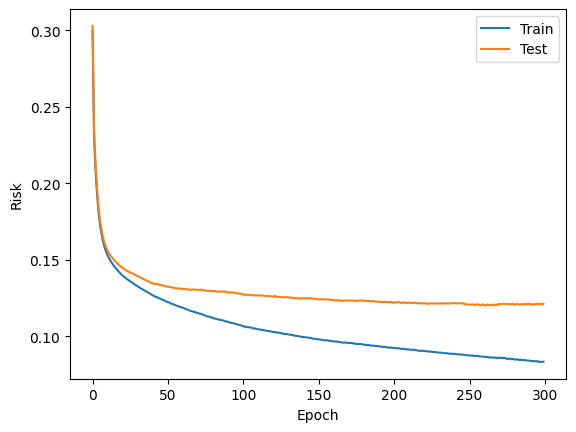

In [38]:
l1_regularized_model = overfitClassifier()
train_risk, test_risk = training_loop(l1_regularized_model, 
                                      l1_regularizer=True,
                                      l1_lambda=0.0001)


plt.plot(train_risk, label='Train')
plt.plot(test_risk, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Risk')
plt.legend()
plt.show()